# Step 3: Making editorial choices, prepare dataframe for merging with geojson file

### Taking our slightly more-cleaned dataframe to do some analysis on it!

In [1]:
import re
import pandas as pd

In [2]:
df = pd.read_csv("cleaned-delays.csv")
df.head()

,date,subject,message,station,cause
0,11/30/22 22:46,"BX, 2 Train, Delays",Northbound 2 trains are delayed while we inves...,Allerton Av,brake
1,11/30/22 22:37,"BKLYN, D and Q Trains, Delays",Northbound D/Q trains are delayed while we add...,DeKalb Av,mechanical problem
2,11/30/22 22:13,"BX, 6 Train, Delays",Northbound 6 trains are running with delays af...,Buhre Av,switch
3,11/30/22 22:06,"MANH, D Train, Delays",Northbound D trains are delayed while we inves...,Broadway-Lafayette St,brake
4,11/30/22 21:37,"BKLYN, D and N Trains, Delays",Northbound D/N trains are delayed while we inv...,36 St,brake


## Categorizing Cause of Delays

Since regex could only do so much to extract the cause for delays, we need to further classify the causes of delays into bigger categories.

The MTA does not have a public guidebook/code for categorizing cause of delays, so editorial decisions are made here to narrow all the cause for delays into 13 categories. *Note: The categories does not reflect how MTA categorize their delays.*

### The categories are:
- **Brake Malfunction**: delays caused by brake being activated.
- **Track Maintenance**: delayed caused by track work, rails replacement, and removing low-hanging wires over tracks, cleaning off stuff on the tracks.
- **Disruptive Passenger**: delays caused by disruptive passenger on trains/platforms, unauthorize person on the tracks, customer altercation, and people riding on the train.
- **Mechanical Problem**: delays caused by "mechnical problem" and door malfunction. 
- **Medical Emergency**: delays caused by people needing medical help, EMS activity, person struck by train.
- **Signal Malfunction**: delays caused by signal malfunction.
- **Power Outage**: train power outages caused by power outages.
- **Switch Malfunction**: delays caused by "switch problem."
- **Cleaning trains**: delays caused by the crew removing trains in need of cleaning, removing vandalizied cars.
- **Police Activity**: delays caused by NYPD conducting investigations on the train/in the station.
- **Fire or Flooding**: delays caused by FDNY, track on fire, smoke in trains, water on tracks.
- **Other**: rare events such as removing dog on track, making way for garbage trains to run on tracks, communications issues. 
- **Unknown Cause**: delays with unspecified cause, including causes marked as "na" (done maunally), and message that says "We're running as much service as we can."

*See ```category_keys.csv``` for the full list of category and keywords (cause column) that fall into each category.*

In [3]:
# import category_key.csv
key_df = pd.read_csv("category-keys.csv")
key_df['category_name'] = key_df.category_name.str.title().str.replace('Or', 'or')
key_df.head()

,key,category_name
0,brake,Brake Malfunction
1,disruptive,Disruptive Passenger
2,mechanical problem,Mechanical Problem
3,EMS,Medical Emergency
4,signal,Singal Malfunction


In [4]:
# matching the categories based on the cause column, merge and make a new dataframe
category_df = pd.merge(df, key_df, how = 'left', left_on = 'cause', right_on = 'key')
category_df.head()

,date,subject,message,station,cause,key,category_name
0,11/30/22 22:46,"BX, 2 Train, Delays",Northbound 2 trains are delayed while we inves...,Allerton Av,brake,brake,Brake Malfunction
1,11/30/22 22:37,"BKLYN, D and Q Trains, Delays",Northbound D/Q trains are delayed while we add...,DeKalb Av,mechanical problem,mechanical problem,Mechanical Problem
2,11/30/22 22:13,"BX, 6 Train, Delays",Northbound 6 trains are running with delays af...,Buhre Av,switch,switch,Switch Malfunction
3,11/30/22 22:06,"MANH, D Train, Delays",Northbound D trains are delayed while we inves...,Broadway-Lafayette St,brake,brake,Brake Malfunction
4,11/30/22 21:37,"BKLYN, D and N Trains, Delays",Northbound D/N trains are delayed while we inv...,36 St,brake,brake,Brake Malfunction


## Expanding the line column and transform it for final dataframe

**Below are the reasons why I chose to base my geolocation on line instead of station:**
- A few subway stations bare the same name. *Example: There are three "103 St" in upper Manhattan.*
- The MTA alerts did not specify the station in situations where stations share the same name. 
- Some stations that share the same name are not differentiated in the shape file provided by the MTA (retrieved from *[NYC Open Data](https://data.cityofnewyork.us/Transportation/Subway-Stations/arq3-7z49)*)
- Some alerts did not specify where interruptions happened. Some interruptions also happened between stops, or happened in multiple stops and lines, making it difficult to pinpoint a single location that caused a delay.


In [5]:
sub_list = category_df.subject.to_list()
all_data = []
pattern = r"^((?:(?:MANH|BKLYN|SI|QNS|BX), )+)(.+) Trains*, (.*)$"
alt_pattern = r"^(.+) Trains*, (.*)"
for row in sub_list:
    data = {}
    if re.match(pattern, row):
        borough_str, lines_str, reason = re.findall(pattern, row)[0]
        boroughs = [x.strip() for x in re.split(", ", borough_str) if x.strip()!=""]
        lines = [x.strip() for x in re.split("and|,", lines_str) if x.strip()!=""]
        data['borough'] = boroughs
        data['line'] = lines
        data['reason'] = reason
        all_data.append(data)
    else:
        boroughs = []
        lines_str, reason = re.findall(alt_pattern, row)[0]
        lines = [x.strip() for x in re.split("and|,", lines_str) if x.strip()!=""]
        data['borough'] = boroughs
        data['line'] = lines
        data['reason'] = reason
        all_data.append(data)

subject_df = pd.DataFrame(all_data)

merged_df = pd.concat([category_df, subject_df], axis=1)

In [6]:
merged_df.head(2)

,date,subject,message,station,cause,key,category_name,borough,line,reason
0,11/30/22 22:46,"BX, 2 Train, Delays",Northbound 2 trains are delayed while we inves...,Allerton Av,brake,brake,Brake Malfunction,[BX],[2],Delays
1,11/30/22 22:37,"BKLYN, D and Q Trains, Delays",Northbound D/Q trains are delayed while we add...,DeKalb Av,mechanical problem,mechanical problem,Mechanical Problem,[BKLYN],"[D, Q]",Delays


In [7]:
# Make a long dataframe based on line column
long_df = merged_df.explode('line')
long_df.head()

,date,subject,message,station,cause,key,category_name,borough,line,reason
0,11/30/22 22:46,"BX, 2 Train, Delays",Northbound 2 trains are delayed while we inves...,Allerton Av,brake,brake,Brake Malfunction,[BX],2,Delays
1,11/30/22 22:37,"BKLYN, D and Q Trains, Delays",Northbound D/Q trains are delayed while we add...,DeKalb Av,mechanical problem,mechanical problem,Mechanical Problem,[BKLYN],D,Delays
1,11/30/22 22:37,"BKLYN, D and Q Trains, Delays",Northbound D/Q trains are delayed while we add...,DeKalb Av,mechanical problem,mechanical problem,Mechanical Problem,[BKLYN],Q,Delays
2,11/30/22 22:13,"BX, 6 Train, Delays",Northbound 6 trains are running with delays af...,Buhre Av,switch,switch,Switch Malfunction,[BX],6,Delays
3,11/30/22 22:06,"MANH, D Train, Delays",Northbound D trains are delayed while we inves...,Broadway-Lafayette St,brake,brake,Brake Malfunction,[MANH],D,Delays


<AxesSubplot: >

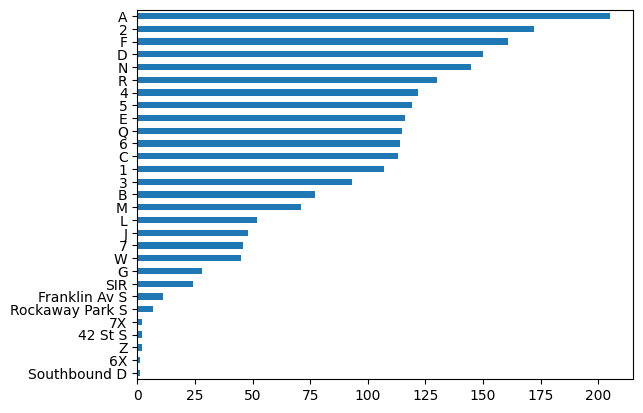

In [10]:
long_df.line.value_counts(ascending=True).plot(kind='barh')

<AxesSubplot: >

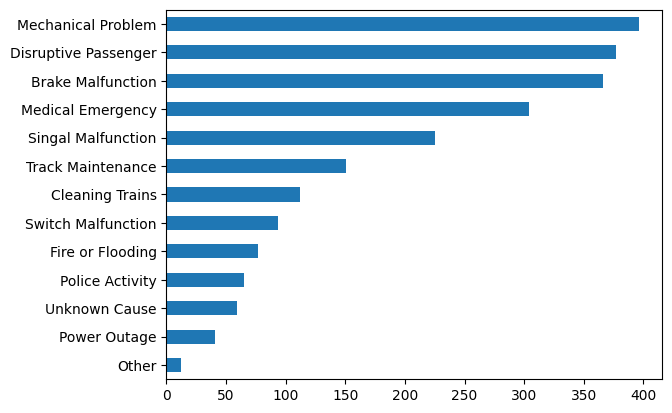

In [12]:
long_df['category_name'].value_counts(ascending=True).plot(kind='barh')

In [9]:
long_df.to_csv("delays-by-category-line-cleaned.csv", index = False)

See notebook ```Step 04 - Processed for final Data frame``` for final data frame.